# **Setting up Libraries**

In [ ]:
!pip install deepspeech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install speechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!curl -LO https://github.com/mozilla/DeepSpeech/releases/download/v0.9.3/deepspeech-0.9.3-models.pbmm
!curl -LO https://github.com/mozilla/DeepSpeech/releases/download/v0.9.3/deepspeech-0.9.3-models.scorer

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180M  100  180M    0     0  53.9M      0  0:00:03  0:00:03 --:--:-- 68.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  909M  100  909M    0     0  65.9M      0  0:00:13  0:00:13 --:--:-- 70.3M


In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io.wavfile as wav
import math
from IPython.display import Audio, display
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import soundfile
import random
from gtts import gTTS
import deepspeech
import wave
import scipy.io.wavfile as wav

In [ ]:
model = deepspeech.Model('deepspeech-0.9.3-models.pbmm')
audio_file = 'normal0.wav'
scorer_file_path = 'deepspeech-0.9.3-models.scorer'
scorer = model.enableExternalScorer(scorer_file_path)
model.trainable = False

In [ ]:
# Define function to transcribe audio using the DeepSpeech model and scorer
def transcribe_audio(audio_file_path, model):
    # Read audio file
    with wave.open(audio_file_path, 'rb') as audio_file:
        audio = audio_file.readframes(audio_file.getnframes())
        audio = np.frombuffer(audio, dtype=np.int16)

    # Transcribe audio
    transcription = model.stt(audio)
    return transcription

In [ ]:
!pip install ds_ctcdecoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#FLAGS
output = '/content/Outputs'
lr = 100
iterations = 1000
l2penalty = float('inf')
lang = 'en'

In [ ]:
#@title ## Enter Original Audio File

#@markdown ---
#@markdown ### Enter a file path:
input = "normal0.wav" #@param {type:"string"}
#@markdown ---



In [ ]:
original_transcription = transcribe_audio(input, model)
print('Original Transcription:', original_transcription)

Original Transcription: without the data the article useless


In [ ]:
ipd.Audio(input)

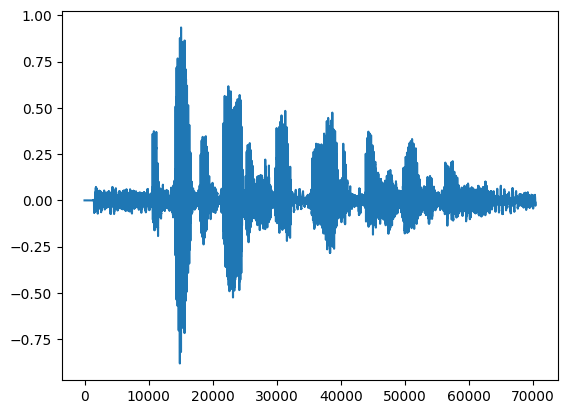

In [ ]:
scale, sr = librosa.load(input)
plt.plot(scale)

In [ ]:
#@title Enter Target Phrase
target = "the quick brown fox jumps over the lazy dog" #@param {type:"string"}
print(target)



from gtts import gTTS
language = 'en'
myobj = gTTS(text=target, lang=language, slow=False)
# print(myobj)
myobj.save('/content/sample_data/mnist.wav')

import librosa
import soundfile as sf
x,_ = librosa.load('/content/sample_data/mnist.wav', sr=16000)
sf.write('tmp/adv1.wav', x, 16000)

the quick brown fox jumps over the lazy dog


In [ ]:
fs, audioip = wav.read(input)
assert audioip.dtype == np.int16

audios = []
lengths = []
source_dB = 20 * np.log10(np.max(np.abs(audioip)))
length = len(audioip)
audios.append(list(audioip))
lengths.append(len(audioip))

In [ ]:
#Just tere to check not important
maxlen = max(map(len,audios))
audios = np.array([x+[0]*(maxlen-len(x)) for x in audios])

In [ ]:
phrase = target
print("\nAttack phrase: ", phrase)


Attack phrase:  the quick brown fox jumps over the lazy dog


In [ ]:
print("Start attack..\n")
batch_size = 1
phrase_length = len(original_transcription)
max_audio_len = len(audioip)
learning_rate = 10

#Initializing everything
delta = tf.Variable(np.zeros((batch_size, max_audio_len), dtype=np.float32), name='qq_delta',trainable = True)
mask = tf.Variable(np.zeros((batch_size, max_audio_len), dtype=np.float32), name='qq_mask')
original = tf.Variable(np.zeros((batch_size, max_audio_len), dtype=np.float32), name='qq_original')
target_phrase = tf.Variable(np.zeros((batch_size, phrase_length), dtype=np.int32), name='qq_phrase')
target_phrase_lengths = tf.Variable(np.zeros((batch_size), dtype=np.int32), name='qq_phrase_lengths')
lengths = tf.Variable(np.zeros(batch_size, dtype=np.int32), name='qq_lengths')
rescale = tf.Variable(np.zeros((batch_size,1), dtype=np.float32), name='qq_phrase_lengths')
cwmask = tf.Variable(np.zeros((batch_size, phrase_length), dtype=np.float32), name='qq_cwmask')
importance = tf.Variable(np.zeros((batch_size, phrase_length), dtype=np.float32), name='qq_importance')

Start attack..



In [ ]:
# bound the l_infty norm by 2000
apply_delta = tf.clip_by_value(delta, -2000, 2000)*rescale

# set the new input to the model to be the above delta plus a mask
new_input = apply_delta*mask + original

# add a tiny bit of noise
noise = tf.random.normal(new_input.shape,stddev=2)
pass_in = tf.clip_by_value(new_input+noise, -2**15, 2**15-1)
audio = pass_in

In [ ]:
print(pass_in)

tf.Tensor(
[[-0.93684435 -0.46012434 -1.6438241  ... -1.1825017   2.3620782
  -1.5148956 ]], shape=(1, 51072), dtype=float32)


In [ ]:
#Defining a window function
def periodic_hann_window(window_length, dtype):
    return 0.5 - 0.5 * tf.math.cos(2.0 * np.pi * tf.range(tf.cast(window_length,tf.float32), dtype=dtype) / (tf.cast(window_length,tf.float32)))

# Scale audio to values between -1 and 1
audio = tf.cast(audio / 2 ** 15, tf.float32)
print(audio.shape)
# performs short-time Fourier transform (STFT) on the audio signal
stfts = tf.signal.stft(
        audio,
        frame_length=512,
        frame_step=320,
        fft_length=512,
        window_fn=periodic_hann_window)

# power spectral density of the audio signal at each time-frequency point in the STFT
spectrogram = tf.square(tf.abs(stfts))

(1, 51072)


In [ ]:
_MEL_BREAK_FREQUENCY_HERTZ = 700.0
_MEL_HIGH_FREQUENCY_Q = 1127.0
filterbank_channel_count = 40
lower_edge_hertz=20.0
upper_edge_hertz=8000.0
sample_rate=16000

def freq2mel(frequencies_hertz):
    """Convert frequency to mel frequency"""
    return _MEL_HIGH_FREQUENCY_Q * np.log1p(frequencies_hertz / _MEL_BREAK_FREQUENCY_HERTZ)

# print(spectrogram.dtype)
input_length = spectrogram.shape[-1] #is 257
batch_size = spectrogram.shape[0] #is 1
center_freqs = np.zeros((filterbank_channel_count + 1,))
mel_low = freq2mel(lower_edge_hertz)
mel_high = freq2mel(upper_edge_hertz)
mel_span = mel_high - mel_low
mel_spacing = mel_span / (filterbank_channel_count + 1)
for i in range(filterbank_channel_count + 1):
    center_freqs[i] = mel_low + (mel_spacing * (i + 1))

hz_per_sbin = 0.5 * sample_rate / (input_length - 1)
start_index = int(1.5 + (lower_edge_hertz / hz_per_sbin))
end_index = int(upper_edge_hertz / hz_per_sbin)

band_mapper = np.zeros((input_length,))
channel = 0
for i in range(input_length):
    melf = freq2mel(i * hz_per_sbin)
    if (i < start_index) or (i > end_index):
        band_mapper[i] = -2
    else:
        while (channel < filterbank_channel_count) and (center_freqs[channel] < melf):
            channel += 1
        band_mapper[i] = channel - 1
weights = np.zeros((input_length,))
for i in range(input_length):
  channel = band_mapper[i]
  if (i < start_index) or (i > end_index):
      weights[i] = 0.0
  else:
      channel = int(channel)
      if (channel >= 0):
          weights[i] = (center_freqs[channel + 1] - freq2mel(i * hz_per_sbin)) / (center_freqs[channel + 1] - center_freqs[channel])
      else:
          weights[i] = (center_freqs[0] - freq2mel(i *hz_per_sbin)) / (center_freqs[0] - mel_low)
bad_channels = []
for c in range(filterbank_channel_count):
    band_weight_sum = 0.0
    for i in range(input_length):
        if band_mapper[i] == (c - 1):
            band_weight_sum += (1.0 - weights[i])
        elif (band_mapper[i] == c):
            band_weight_sum += weights[i]
    if (band_weight_sum < 0.5):
        bad_channels.append(c)
mapping_matrix_w = np.zeros((filterbank_channel_count, input_length))
mapping_matrix_r = np.zeros((filterbank_channel_count, input_length))

for i in range(start_index, end_index):
  channel = int(band_mapper[i])
  if (channel >= 0):
    mapping_matrix_w[channel][i] = 1.0
  channel += 1
  if (channel < filterbank_channel_count):
    mapping_matrix_r[channel][i] = 1.0

mapping_matrix_w = np.stack([mapping_matrix_w] * batch_size, axis=0)
mapping_matrix_r = np.stack([mapping_matrix_r] * batch_size, axis=0)
weights = np.stack([np.stack([weights] * batch_size, axis=0)] * spectrogram.shape[1], axis=1)

spec_val = tf.math.sqrt(spectrogram)
# spec_val_expanded = tf.expand_dims(spec_val, -1)  # expand last dimension
weighted = tf.math.multiply(spec_val, weights)
res = spec_val - weighted

weighted = tf.transpose(weighted, perm=[0, 2, 1])
res = tf.transpose(res, perm=[0, 2, 1])

vals = tf.matmul(tf.cast(mapping_matrix_w, tf.float32), weighted) + tf.matmul(tf.cast(mapping_matrix_r, tf.float32), res)

In [ ]:
kFilterbankFloor = 1e-12
vals = vals * tf.cast(vals > 0, tf.float32) + kFilterbankFloor
log_mel_energies = tf.math.log(vals)

In [ ]:
def create_dct_matrix(dct_coefficient_count=13, filterbank_channel_count=40, dtype=tf.float32):
    fnorm = np.sqrt(2 / filterbank_channel_count)
    arg = np.pi / filterbank_channel_count

    arg_ = np.zeros((dct_coefficient_count, filterbank_channel_count))
    for i in range(dct_coefficient_count):
        for j in range(filterbank_channel_count):
            arg_[i][j] = i * arg * (j + 0.5)

    return fnorm * np.cos(arg_)

In [ ]:
dct_coefficient_count=26

batch_size = log_mel_energies.shape[0]
cosines = create_dct_matrix(dct_coefficient_count, filterbank_channel_count)
cosines = tf.cast(np.stack([cosines] * batch_size, axis=0), tf.float32)
input_length = log_mel_energies.shape[1]
if input_length > filterbank_channel_count:
    input_length = filterbank_channel_count
features = tf.transpose(tf.matmul(cosines[:, :input_length, :], log_mel_energies), perm=[0, 2, 1])
print(features)

tf.Tensor(
[[[-5.0309418e+01 -4.0004659e+00  3.6483192e-01 ... -3.9013803e-02
   -2.4946487e-01 -5.0538522e-01]
  [-5.0675873e+01 -4.4250422e+00  9.5325470e-02 ...  2.0690739e-01
    1.3353157e-01  2.4903107e-01]
  [-5.0134079e+01 -4.7364211e+00  5.6882858e-02 ...  2.0586908e-01
    3.0726594e-01  2.1884654e-01]
  ...
  [-5.0471035e+01 -4.8420038e+00 -8.4664345e-02 ... -1.3360894e-01
    1.2015939e-02 -2.6953876e-01]
  [-5.0643665e+01 -4.4219408e+00  3.7176800e-01 ...  2.8121436e-01
   -2.1463907e-01  2.5563452e-01]
  [-5.1741806e+01 -5.2007651e+00 -3.2761192e-01 ...  5.4614520e-01
    4.5220816e-01 -1.4778247e-01]]], shape=(1, 159, 26), dtype=float32)


In [ ]:
#Create overlapping windows
n_context = 9
n_input = 26

batch_size = tf.shape(input=features)[0]
window_width = 2 * n_context + 1
num_channels = n_input
eye_filter = tf.constant(np.eye(window_width * num_channels).reshape(window_width, num_channels, window_width * num_channels), tf.float32)

print(eye_filter.shape)
features = tf.nn.conv1d(input=features, filters=eye_filter, stride=1, padding='SAME')
print(features)
features = tf.reshape(features, [batch_size, -1, window_width, num_channels])
print(features.shape)
batch_x = features

(19, 26, 494)
tf.Tensor(
[[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.1091664e-01
    1.6245848e-01  2.1583188e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.0418415e-02
    3.3047915e-02  3.3366221e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.8681922e-01
   -3.4779745e-01  1.8407419e-01]
  ...
  [-5.1028126e+01 -5.2920580e+00 -4.1667366e-01 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [-5.0703339e+01 -4.6000767e+00 -6.4665794e-01 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]
  [-5.0792229e+01 -4.5288091e+00  2.2531509e-02 ...  0.0000000e+00
    0.0000000e+00  0.0000000e+00]]], shape=(1, 159, 494), dtype=float32)
(1, 159, 19, 26)


In [ ]:
batch_x = features

In [ ]:
print(batch_x.shape) #Should be (1, 159, 19, 26) otherwise run upper cells from initialization again

(1, 159, 19, 26)


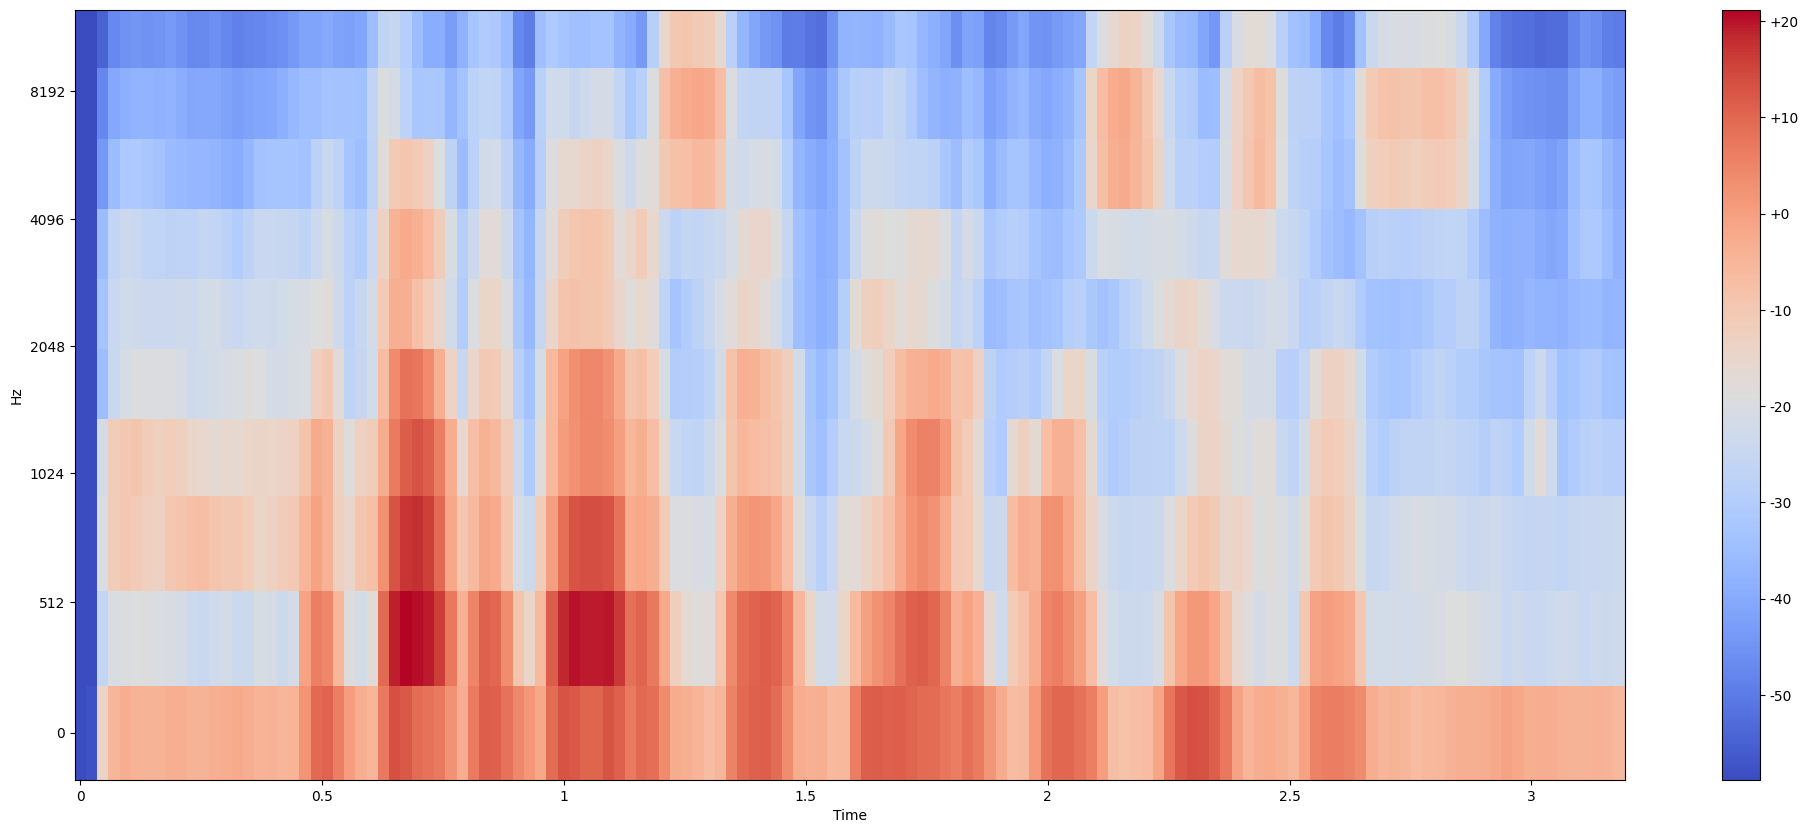

In [ ]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
mel_spectrogram = librosa.feature.melspectrogram(y= scale, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram,
                         x_axis="time",
                         y_axis="mel",
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

Performing Untargeted Attack


In [ ]:
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [ ]:
scale=np.interp(scale, (scale.min(), scale.max()), (-1, 1))
unoise=get_white_noise(scale,SNR=5)

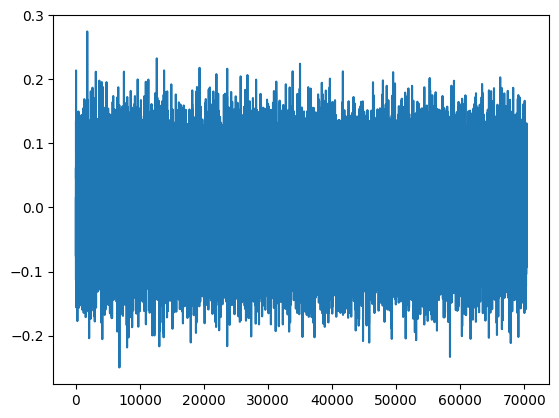

In [ ]:
type(unoise)
plt.plot(unoise)

In [ ]:
noise_audio = Audio._make_wav(unoise,sr,unoise.any())
ipd.Audio(noise_audio)

In [ ]:
signal_noise=scale+unoise

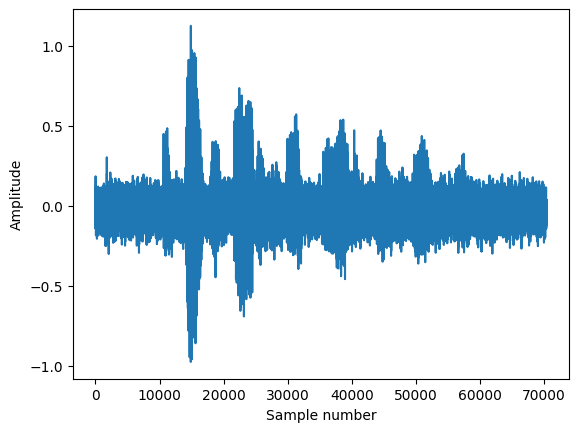

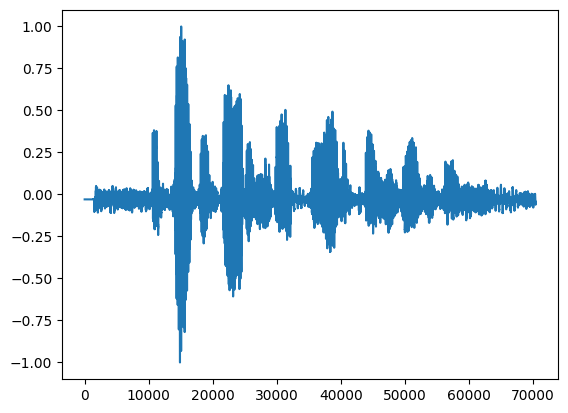

In [ ]:
plt.plot(signal_noise)
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.show()

plt.plot(scale)

In [ ]:
sigaud = Audio._make_wav(signal_noise,sr,signal_noise.any())
ipd.Audio(sigaud)

In [ ]:
import soundfile
soundfile.write('op.wav', signal_noise, sr)

In [ ]:
print(transcribe_audio('op.wav',model))

he felt as brutalities


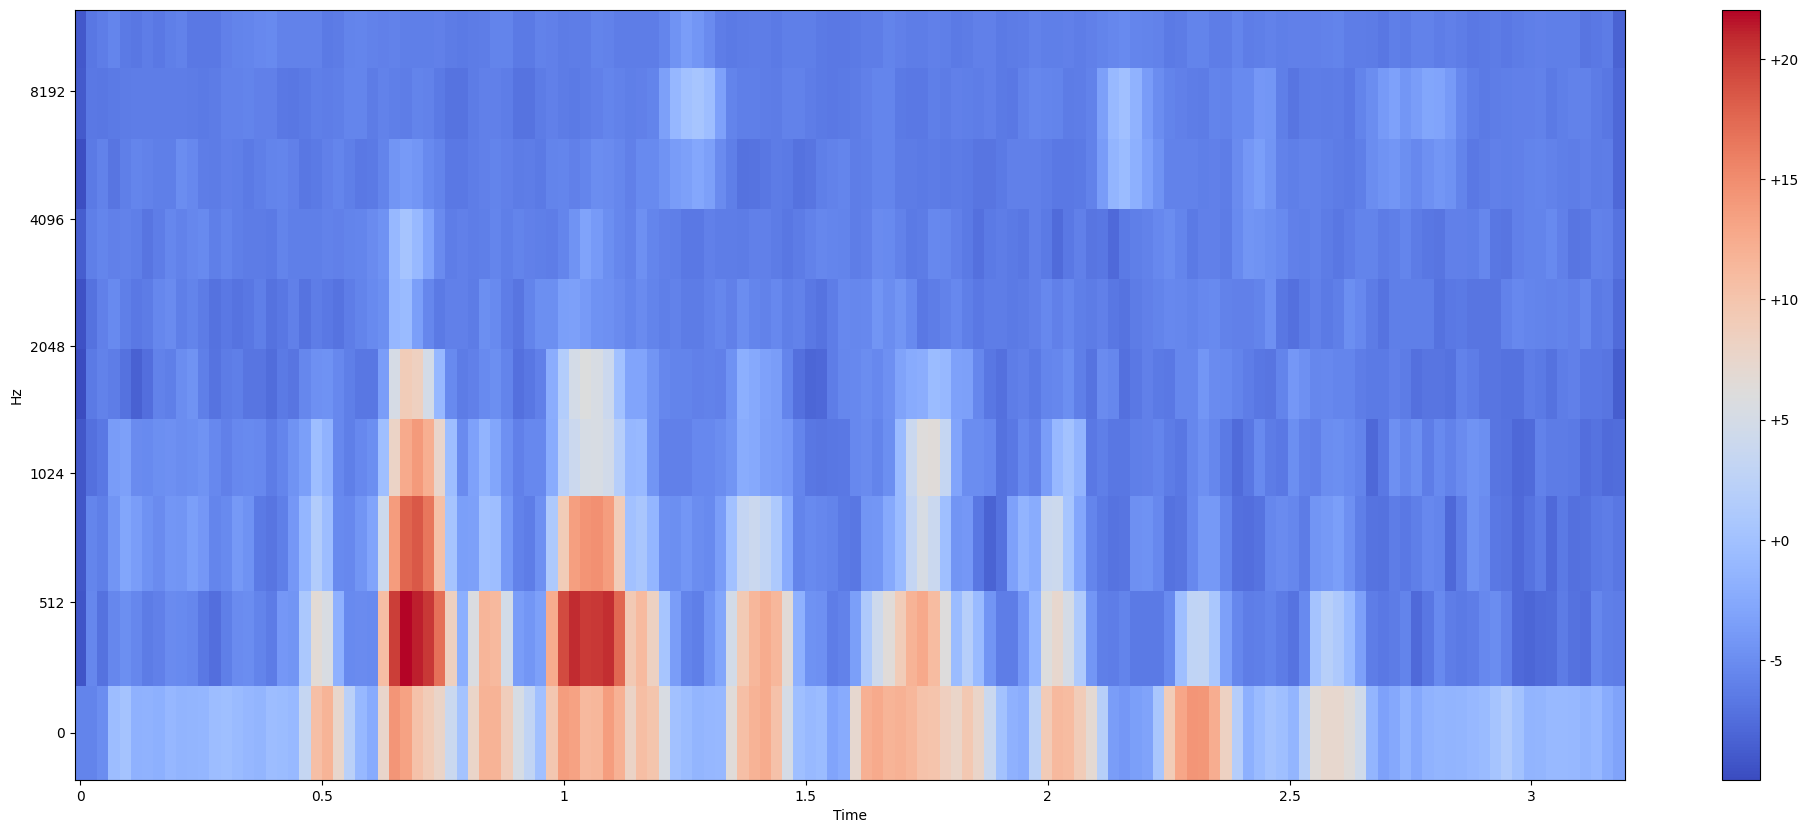

In [ ]:
scale1, sr1 = librosa.load('op.wav')
mel_spectrogram1 = librosa.feature.melspectrogram(y = scale1, sr=sr1, n_fft=2048, hop_length=512, n_mels=10)
log_mel_spectrogram1 = librosa.power_to_db(mel_spectrogram1)
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram1,
                         x_axis="time",
                         y_axis="mel",
                         sr=sr1)
plt.colorbar(format="%+2.f")
plt.show()

Targeted Attack

In [ ]:
#Creating a Neural Network
dropout = no_dropout = [None] * 6

In [ ]:
n_cell_dim = 2048

In [ ]:
import tensorflow.compat.v1 as tfv1
cpu_device = '/cpu:0'
def variable_on_cpu(name, shape, initializer):
    # Use the /cpu:0 device for scoped operations
    with tf.device(cpu_device):
        # Create or get apropos variable
        var = tfv1.get_variable(name=name, shape=shape, initializer=initializer)
    return var

In [ ]:
def dense(name, x, units, dropout_rate=None, relu=True, layer_norm=False):
    with tfv1.variable_scope(name):
        bias = variable_on_cpu('bias', [units], tfv1.zeros_initializer())
        weights = variable_on_cpu('weights', [x.shape[-1], units], tfv1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))

    output = tf.nn.bias_add(tf.matmul(x, weights), bias)

    if relu:
        output = tf.minimum(tf.nn.relu(output), 20.0)

    if layer_norm:
        with tfv1.variable_scope(name):
            output = tf.contrib.layers.layer_norm(output)

    if dropout_rate is not None:
        output = tf.nn.dropout(output, rate=dropout_rate)

    return output

In [ ]:
def rnn_impl_lstmblockfusedcell(x, seq_length, previous_state, reuse):
    # with tfv1.variable_scope('cudnn_lstm/rnn/multi_rnn_cell/cell_0'):
    fw_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(n_cell_dim,
                                                forget_bias=0,
                                                reuse=reuse,
                                                name='cudnn_compatible_lstm_cell')

    output, output_state = fw_cell(inputs=x,
                                    state=previous_state)

    return output, output_state

In [ ]:
from ds_ctcdecoder import Alphabet, UTF8Alphabet
alphabet = UTF8Alphabet()
n_hidden_6 = alphabet.GetSize() + 1

In [ ]:
layers = {}
batch_size = tf.shape(input=batch_x)[0]
batch_x = tf.transpose(a=batch_x, perm=[1 ,0, 2,3])

# Reshape to prepare input for first layer
batch_x = tf.reshape(batch_x, [-1, n_input + 2*n_input*n_context])
layers['input_reshaped'] = batch_x

n_hidden = n_hidden_1 = n_hidden_2 = n_hidden_3 = 2048
# The next three blocks will pass `batch_x` through three hidden layers with
# clipped RELU activation and dropout.
layers['layer_1'] = layer_1 = dense('layer_1', batch_x, n_hidden_1, dropout_rate=dropout[0], layer_norm=False)
layers['layer_2'] = layer_2 = dense('layer_2', layer_1, n_hidden_2, dropout_rate=dropout[1], layer_norm=False)
layers['layer_3'] = layer_3 = dense('layer_3', layer_2, n_hidden_3, dropout_rate=dropout[2], layer_norm=False)

# `layer_3` is now reshaped into `[n_steps, batch_size, 2*n_cell_dim]`,
# as the LSTM RNN expects its input to be of shape `[max_time, batch_size, input_size]`.
# layer_3 = tf.reshape(layer_3, [-1, batch_size, n_hidden_3])

In [ ]:
print(layer_3)

tf.Tensor(
[[0.        0.        0.        ... 0.        0.        3.6955392]
 [0.        0.        0.        ... 0.        0.        5.0338616]
 [0.        0.        0.        ... 0.        0.        5.259865 ]
 ...
 [0.        3.6153703 0.        ... 0.        0.        5.097711 ]
 [0.        2.2521152 0.        ... 0.        0.        5.2770767]
 [0.        3.2861824 0.        ... 0.        0.        3.996466 ]], shape=(159, 2048), dtype=float32)


In [ ]:
# Run through parametrized RNN implementation, as we use different RNNs
# for training and inference
output, output_state = rnn_impl_lstmblockfusedcell(layer_3, seq_length = lengths, previous_state= (tf.zeros([159, n_cell_dim]), tf.zeros([159, n_cell_dim])), reuse = False)

# Reshape output from a tensor of shape [n_steps, batch_size, n_cell_dim]
# to a tensor of shape [n_steps*batch_size, n_cell_dim]
output = tf.reshape(output, [-1,2048])
layers['rnn_output'] = output
layers['rnn_output_state'] = output_state

# Now we feed `output` to the fifth hidden layer with clipped RELU activation
layers['layer_5'] = layer_5 = dense('layer_5', output, 2048, dropout_rate=dropout[5], layer_norm=False)

# Now we apply a final linear layer creating `n_classes` dimensional vectors, the logits.
layers['layer_6'] = layer_6 = dense('layer_6', layer_5, n_hidden_6, relu=False)

# Finally we reshape layer_6 from a tensor of shape [n_steps*batch_size, n_hidden_6]
# to the slightly more useful shape [n_steps, batch_size, n_hidden_6].
# Note, that this differs from the input in that it is time-major.
layer_6 = tf.reshape(layer_6, [-1, batch_size, n_hidden_6], name='raw_logits')
layers['raw_logits'] = layer_6

<ipython-input-185-f4e157cddc86>:3: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  fw_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(n_cell_dim,


In [ ]:
logits = layer_6

In [ ]:
print(logits)

tf.Tensor(
[[[-0.05722924 -0.18301536  0.3209697  ...  0.13473372 -0.0673494
    0.16721949]]

 [[-0.02504763 -0.18094046  0.23569724 ...  0.1896363  -0.04030181
    0.2039997 ]]

 [[ 0.0004572  -0.22160381  0.19986084 ...  0.15783045 -0.1022245
    0.264104  ]]

 ...

 [[-0.09207641 -0.2129975   0.13366276 ... -0.00801806 -0.15647809
    0.20447746]]

 [[-0.09919319 -0.1800594   0.10705718 ...  0.05402669 -0.17424607
    0.14009306]]

 [[-0.1036872  -0.11930148  0.11413547 ...  0.06040898 -0.14619286
    0.15367748]]], shape=(159, 1, 256), dtype=float32)


In [ ]:
target_phrase = target
char_to_label = {char: i for i, char in enumerate(set(target_phrase))}
target_labels = [char_to_label[char] for char in target_phrase]
target_array = np.array(target_labels).reshape((1, len(target_labels)))

In [ ]:
print(target_array)

[[ 3 24 17 16  1 25 11  6  5 16 12 20 22 23  7 16 14 22  9 16 26 25 10  8
   4 16 22 18 17 20 16  3 24 17 16 21 15  2  0 16 19 22 13]]


In [ ]:
phrase_length = len(target_array)
print(phrase_length)

1


In [ ]:
print(target_phrase)

the quick brown fox jumps over the lazy dog


In [ ]:
target_phrase=np.array([list(t)+[0]*(phrase_length-len(t)) for t in target_array])
target_phrase_lengths=np.array([len(x) for x in target_array])

In [ ]:
target_phrase = tf.cast(target_phrase, tf.int32)
target_phrase_lengths = tf.cast(target_phrase_lengths, tf.int32)

In [ ]:
type(target_phrase_lengths)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
from tensorflow.python.keras.backend import ctc_label_dense_to_sparse
# def loss(target_phrase,target_phrase_lengths,logits,new_input,original,l2penalty):
target = ctc_label_dense_to_sparse(target_phrase, target_phrase_lengths)
ctcloss = tf.compat.v1.nn.ctc_loss(labels=tf.cast(target, tf.int32),inputs=logits, sequence_length=target_phrase_lengths)

if not np.isinf(l2penalty):
  loss = tf.reduce_mean((new_input-original)**2,axis=1) + l2penalty*ctcloss
  print('im here')
else:
  loss = ctcloss
expanded_loss = tf.constant(0)
  # return loss

In [ ]:
print(loss)

tf.Tensor([240.79153], shape=(1,), dtype=float32)


In [ ]:
start_vars = set(x.name for x in tf.compat.v1.global_variables())
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
probs = tf.squeeze(tf.nn.softmax(logits, name='logits'))

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(new_input)
  ctcloss = tf.compat.v1.nn.ctc_loss(labels=tf.cast(target, tf.int32),inputs=logits, sequence_length=target_phrase_lengths)
  loss = tf.reduce_mean((new_input-original)*2,axis=1) + l2penalty*ctcloss
grad,var = zip(optimizer.compute_gradients(loss, [new_input],tape=tape)[0])
# grad_var = zip(optimizer.compute_gradients(loss, [new_input],tape=tape)[0])
train = optimizer.apply_gradients(grad_var)

In [ ]:
tf.compat.v1.variables_initializer([delta])

In [ ]:
audio_sample_rate = 16000
feature_win_step = 20
audio_step_samples = audio_sample_rate * (feature_win_step / 1000)

original.assign(np.array(audioip).reshape((1, 51072)))
lengths = ((np.array(lengths)-(2*audio_step_samples/3))//320)
mask.assign(np.array([[1 if i < l else 0 for i in range(max_audio_len)] for l in lengths]))
# cwmask.assign(np.array([[1 if i < l else 0 for i in range(phrase_length)] for l in (np.array(lengths)-1)//320]))
target_phrase=np.array([list(t)+[0]*(phrase_length-len(t)) for t in target_array])
target_phrase_lengths=np.array([len(x) for x in target_array])
importance = np.ones((batch_size, phrase_length))
rescale = np.ones((batch_size,1))

In [ ]:
batch_size = 1
final_deltas = [None]*batch_size

In [ ]:
MAX = num_iterations = 5000
first_hits = np.zeros((batch_size,))
best_hits = np.zeros((batch_size,))

In [ ]:
probs = tf.squeeze(tf.nn.softmax(logits, name='logits'))

In [ ]:
toks = " abcdefghijklmnopqrstuvwxyz'-"

In [ ]:
from ds_ctcdecoder import ctc_beam_search_decoder, Scorer
lm_alpha = 0.931289039105002
lm_beta = 1.1834137581510284
scorer_path = '/content/deepspeech-0.9.3-models.scorer'
alphabet = UTF8Alphabet()
scorer = Scorer(lm_alpha, lm_beta,scorer_path, alphabet)
decoded, _ = tf.nn.ctc_beam_search_decoder(logits, lengths, beam_width=100)

In [ ]:
loss_fn = 'CTC'

In [ ]:
target = [[toks.index(x) for x in phrase]]*len(audios)

In [ ]:
print(logits.shape)

(159, 1, 256)


In [ ]:
# logits = tf.cast(logits, tf.float32)
# probs = tf.nn.softmax(logits, name='logits')
# probs = tf.reshape(probs, [1, -1])
# print(probs)

In [ ]:
for i in range(5000):
  if i%100== 0:
    print(i)
    new, delta, probs_out, r_logits = new_input, delta, probs, logits
    lst = [(probs_out, r_logits)]
    batch_size = r_logits.shape[1]
    for out, logits in lst:
      out_list = []
      for ii in range(batch_size):
          if batch_size == 1:
              probs = probs_out
          else:
              probs = probs_out[:,ii,:]
          decoded = tf.nn.ctc_beam_search_decoder(logits, lengths, beam_width=1000)
          out_list.append(decoded)
  d, el, cl, l, logits, new_input, _ = delta, expanded_loss, ctcloss, loss, logits, new_input, train
  for ii in range(batch_size):
      if (loss_fn == "CTC" and i%10 == 0 and out_list[ii] != "".join([toks[x] for x in target[ii]])) \
          or (i == MAX-1 and final_deltas[ii] is not None):
          rescale = rescale
          if rescale[ii]*2000 > np.max(np.abs(d)):
              rescale[ii] = np.max(np.abs(d[ii]))/2000.0

          rescale[ii] *= .8

          final_deltas[ii] = new_input[ii]

          if (first_hits[ii] == 0):
              first_hits[ii]=i
          else:
              best_hits[ii]=i

          rescale = rescale
          wav.write("tmp/advl.wav", 16000, np.array(np.clip(np.round(new_input[ii]), -2**15, 2**15-1),dtype=np.int16))


In [ ]:
ipd.Audio('tmp/advl.wav')

In [ ]:
transcribe_audio('tmp/advl.wav',model)

'the quick brown fox jumps over the lazy dog'

In [ ]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment

# Load audio file
audio = AudioSegment.from_file("tmp/advl.wav", format="wav")

# Export audio in MP3 format
audio.export("output.mp3", format="mp3")

<_io.BufferedRandom name='output.mp3'>

In [ ]:
ipd.Audio('output.mp3')